In [ ]:
import numpy as np
import pandas as pd
import json
import re
import string
import nltk
from nltk.corpus import stopwords
import spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split,GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = open('/content/drive/MyDrive/Scania/complaints-2021-05-14_08_16.json')

In [ ]:
data = json.load(f)

In [ ]:
data = pd.json_normalize(data)

In [ ]:
data.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
data.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
data = data[['_source.complaint_what_happened','_source.product','_source.sub_product']]

In [ ]:
data.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
data = data.rename(columns={'_source.complaint_what_happened' : 'complaint_text', '_source.product' : 'category', '_source.sub_product' : 'sub_category'})

In [ ]:
data.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
data['category'] = data['category'] + ' + ' + data['sub_category']
data = data.drop(['sub_category'],axis = 1)
data.head()

,complaint_text,category
0,,Debt collection + Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection + Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card + General-purpose ...
3,,Mortgage + Conventional home mortgage
4,,Credit card or prepaid card + General-purpose ...


In [ ]:
data.complaint_text.isnull().sum()

0

In [ ]:
len(data[data['complaint_text'] ==""])

57241

In [ ]:
data[data['complaint_text']==""] = np.nan
data.complaint_text.isnull().sum()

57241

In [ ]:
data = data[~data['complaint_text'].isnull()]
data.complaint_text.isnull().sum()

0

In [ ]:
# data.dropna(axis= 0, subset=['complaint_text'],inplace = True)

In [ ]:
data.complaint_text.isnull().sum()

0

In [ ]:
def remove(text):
    text = text.lower()
    text = re.sub('\[.*\]','', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\S*\d\S*\s*','', text).strip()
    return text.strip()

In [ ]:
data.complaint_text = data.complaint_text.apply(lambda x : remove(x))
data.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize(x):
  text = word_tokenize(x)
  words = [word for word in text if word not in stop_words]
  lemma_words = [lemmatizer.lemmatize(word, pos = wordnet.VERB) for word in words]
  return ' '.join(lemma_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data['lemma'] = data.complaint_text.apply(lambda x : lemmatize(x))

In [ ]:
data.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection + Credit card debt,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card + General-purpose ...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report however fraudulent applicati...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for i deposit it in...,Checking or savings account + Checking account,grand son give check deposit chase account fun...


In [ ]:
data_clean = data[['complaint_text','lemma','category']]
data_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account


In [ ]:
data.shape

(21072, 3)

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def extract_nouns(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    nouns = [word for word, pos in pos_tags if pos == 'NN']
    return ' '.join(nouns)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
data_clean['complaint_pos_removed'] = data_clean['lemma'].apply(lambda x : extract_nouns(x))
data_clean.head()

<ipython-input-28-ce5dc89140a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['complaint_pos_removed'] = data_clean['lemma'].apply(lambda x : extract_nouns(x))


,complaint_text,lemma,category,complaint_pos_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt,morning name appreciate chase bank cardmember ...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...,card tell agent date information order upgrade...
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o...",book ticket come offer apply ticket card infor...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account,son check deposit chase account fund bank acco...


(array([8.005e+03, 6.492e+03, 3.094e+03, 1.477e+03, 9.090e+02, 4.800e+02,
        2.170e+02, 1.130e+02, 6.300e+01, 5.100e+01, 4.000e+01, 2.400e+01,
        1.500e+01, 2.100e+01, 1.300e+01, 8.000e+00, 1.000e+01, 3.000e+00,
        6.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([    0.  ,   220.56,   441.12,   661.68,   882.24,  1102.8 ,
         1323.36,  1543.92,  1764.48,  1985.04,  2205.6 ,  2426.16,
         2646.72,  2867.28,  3087.84,  3308.4 ,  3528.96,  3749.52,
         3970.08,  4190.64,  4411.2 ,  4631.76,  4852.32,  5072.88,
         5293.44,  5514.  ,  5734.56,  5955.12,  6175.68,  6396.24,
         6616.8 ,  6837.36,  7057.92

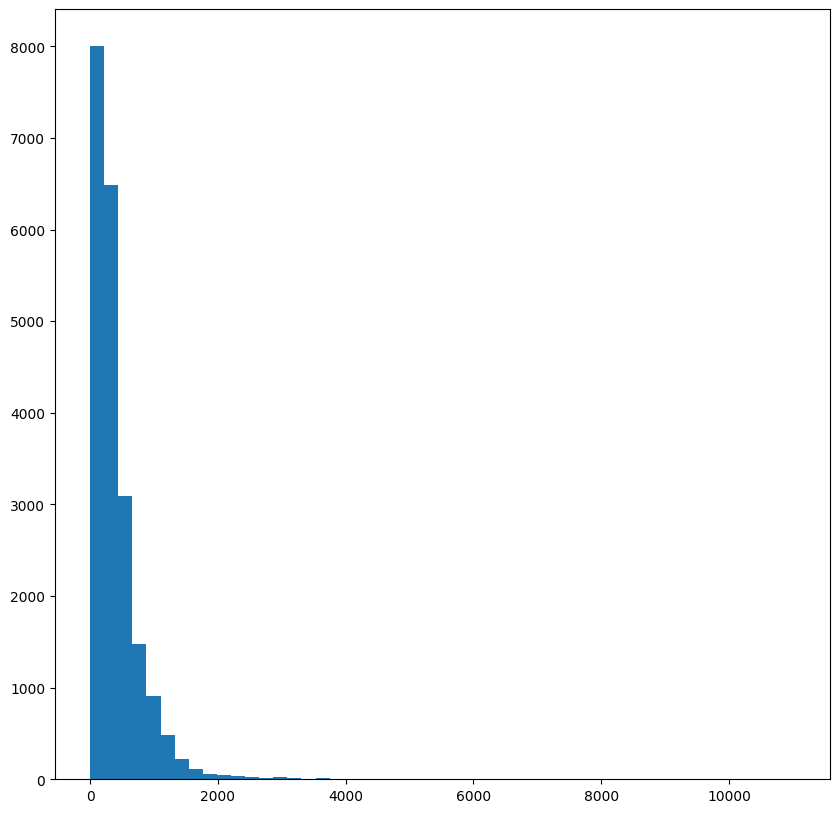

In [ ]:
fig = plt.figure(figsize=(10,10))
text_lens = [len(s) for s in data_clean.complaint_pos_removed]
plt.hist(text_lens, bins = 50)

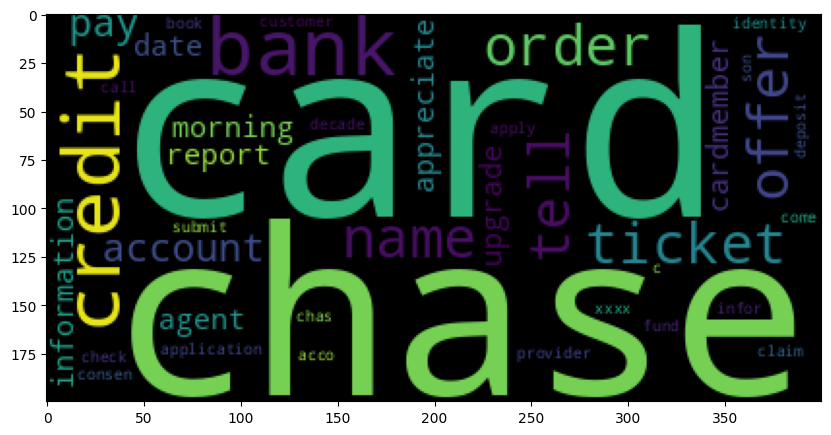

In [ ]:
from wordcloud import WordCloud
fig = plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords = stop_words, max_words = 40).generate(str(data_clean.complaint_pos_removed))
print(wordcloud)
plt.imshow(wordcloud)
plt.show()

In [ ]:
data_clean['complaint_clean'] = data_clean['complaint_pos_removed'].str.replace('-PRON-','')
data_clean = data_clean.drop(['complaint_pos_removed'],axis=1)

<ipython-input-31-939aa139c9c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['complaint_clean'] = data_clean['complaint_pos_removed'].str.replace('-PRON-','')


In [ ]:
data_clean.head()

,complaint_text,lemma,category,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt,morning name appreciate chase bank cardmember ...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...,card tell agent date information order upgrade...
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o...",book ticket come offer apply ticket card infor...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account,son check deposit chase account fund bank acco...


In [ ]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [ ]:
top_30_unigrams = get_top_n_bigram(data_clean.complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(data_clean.complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(data_clean.complaint_clean,ngram=3, top=30)

In [ ]:
top_30_unigrams[:10]

[('chase', 51779),
 ('account', 42460),
 ('credit', 34156),
 ('bank', 30027),
 ('card', 26221),
 ('charge', 16817),
 ('time', 16097),
 ('payment', 13946),
 ('xxxx', 13215),
 ('check', 12887)]

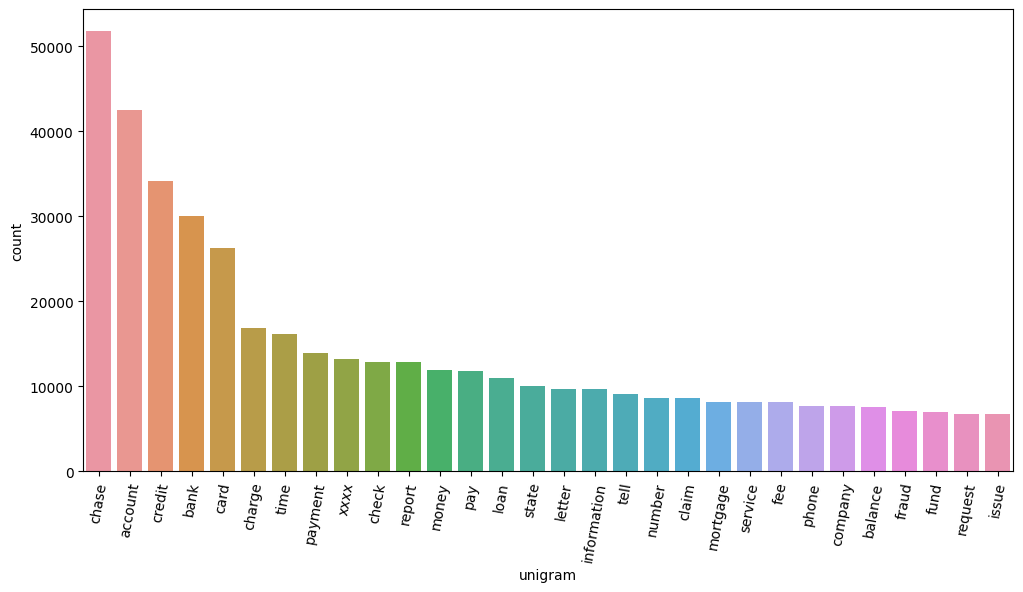

In [ ]:
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
top_30_bigrams[:10]

[('credit card', 12616),
 ('chase bank', 5327),
 ('credit report', 5035),
 ('check account', 4092),
 ('customer service', 3066),
 ('chase credit', 2978),
 ('bank account', 2673),
 ('account chase', 2305),
 ('chase account', 2010),
 ('account account', 1905)]

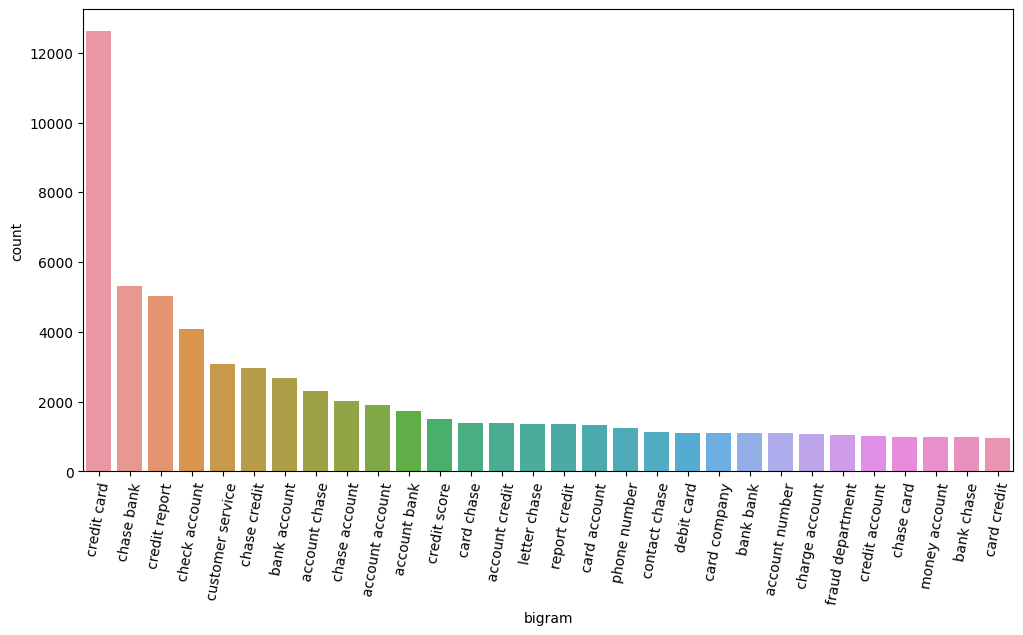

In [ ]:
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
top_30_trigrams[:10]

[('chase credit card', 2086),
 ('credit card company', 1006),
 ('credit card account', 914),
 ('credit card chase', 738),
 ('credit card credit', 572),
 ('charge credit card', 491),
 ('chase customer service', 490),
 ('credit report credit', 472),
 ('report credit report', 451),
 ('chase check account', 423)]

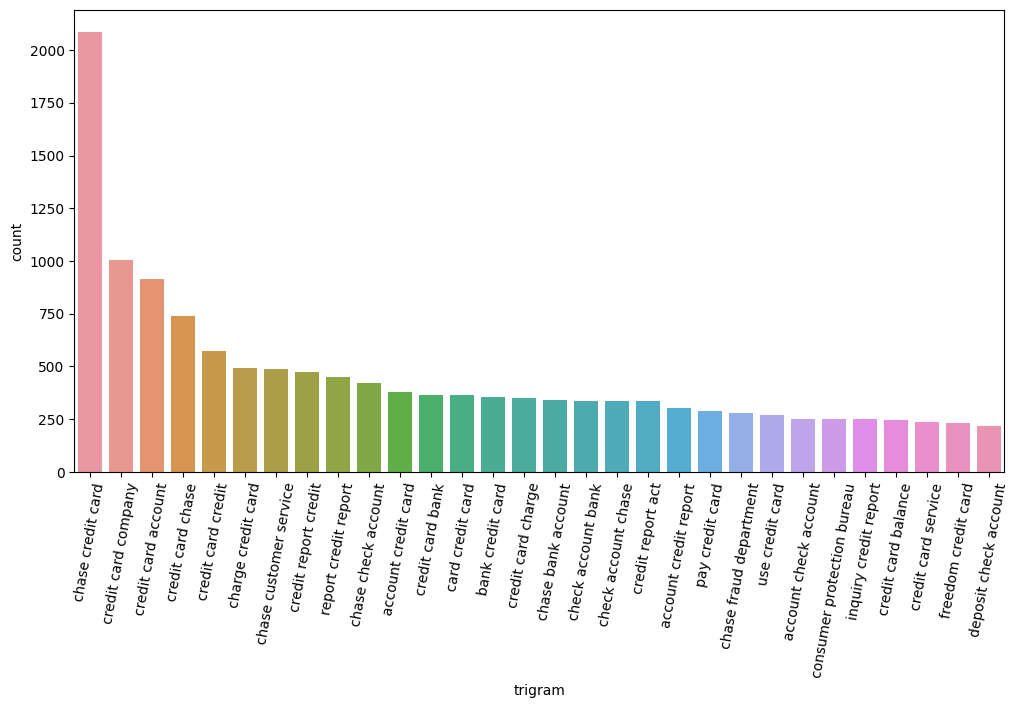

In [ ]:
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
data_clean.head()

,complaint_text,lemma,category,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt,morning name appreciate chase bank cardmember ...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...,card tell agent date information order upgrade...
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o...",book ticket come offer apply ticket card infor...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account,son check deposit chase account fund bank acco...


In [ ]:
data_clean['complaint_clean'] = data_clean['complaint_clean'].str.replace('xxxx','')

In [ ]:
data_clean.head()

,complaint_text,lemma,category,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt,morning name appreciate chase bank cardmember ...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...,card tell agent date information order upgrade...
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o...",book ticket come offer apply ticket card infor...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account,son check deposit chase account fund bank acco...


In [ ]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.95, stop_words = 'english')

In [ ]:
dtm = tfidf.fit_transform(data_clean.complaint_clean)

In [ ]:
tfidf.get_feature_names_out()[:10]

array(['aarp', 'aback', 'abandon', 'abandonment', 'abatement',
       'abbreviation', 'abd', 'abet', 'abhorrent', 'abide'], dtype=object)

In [ ]:
len(tfidf.get_feature_names_out())

6745

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
num_topics =  5

nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [ ]:
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [ ]:
vocab

array(['aarp', 'aback', 'abandon', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [ ]:
topics

['account bank check money chase deposit fund branch tell number transfer claim business fraud cash',
 'credit report card chase inquiry account company score information debt limit letter application use bureaus',
 'loan mortgage home chase modification property letter time house refinance bank rate document foreclosure sale',
 'charge card chase fee dispute purchase merchant fraud claim transaction refund service time company pay',
 'payment balance pay fee month statement auto date time account chase day transfer car post']

In [ ]:
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data_clean.complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.01,0.02,0.01,0.01,0
Doc1,0.01,0.01,0.01,0.01,0.00,0
Doc2,0.00,0.06,0.00,0.00,0.00,1
Doc3,0.02,0.06,0.02,0.01,0.00,1
Doc4,0.08,0.00,0.00,0.00,0.00,0


In [ ]:
data_clean['Topic'] = significant_topic

In [ ]:
data_clean.head()

,complaint_text,lemma,category,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt,morning name appreciate chase bank cardmember ...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...,card tell agent date information order upgrade...,0
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o...",book ticket come offer apply ticket card infor...,1
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account,son check deposit chase account fund bank acco...,0


In [ ]:
data_clean['Topic'].isnull().sum()

0

In [ ]:
temp = data_clean[['complaint_text','complaint_clean','category','Topic']].groupby('Topic').head(10)
temp.sort_values('Topic')

,complaint_text,complaint_clean,category,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,Debt collection + Credit card debt,0
2,i upgraded my xxxx xxxx card in and was told b...,card tell agent date information order upgrade...,Credit card or prepaid card + General-purpose ...,0
14,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,Checking or savings account + Checking account,0
17,with out notice jp morgan chase restricted my ...,jp restrict account debit card tuesday thursda...,Checking or savings account + Checking account,0
48,jp morgan chase bank please answer the followi...,jp bank please question access information rea...,Checking or savings account + Checking account,0
43,chase sent me an email today with the innocuou...,send email today title information regard chan...,Credit card or prepaid card + General-purpose ...,0
24,mishandling of this account by chase auto and ...,account auto,Vehicle loan or lease + Loan,0
42,my card went missing and i didnt realize it un...,card didnt realize today deposit money bank ac...,Checking or savings account + Checking account,0
27,i opened an account with chase bank on xxxx an...,account bank use code bonus call term tell ev...,Checking or savings account + Checking account,0
35,i opened the saving account for the bonus i wa...,save account bonus bonus auto transfer check t...,Checking or savings account + Savings account,0


In [ ]:
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

data_clean['Topic'] = data_clean['Topic'].map(topic_mapping)

In [ ]:
data_clean

,complaint_text,lemma,category,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,Debt collection + Credit card debt,morning name appreciate chase bank cardmember ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card + General-purpose ...,card tell agent date information order upgrade...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report however fraudulent applicati...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come across offer ap...,"Credit reporting, credit repair services, or o...",book ticket come offer apply ticket card infor...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,Checking or savings account + Checking account,son check deposit chase account fund bank acco...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,Credit card or prepaid card + General-purpose ...,chase card customer decade offer credit card c...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,Credit card or prepaid card + General-purpose ...,call chas credit card provider claim purchase...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account + Checking account,pay risk chase bank bank tell deal merchant me...,Bank Account services
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ive chase credit card chas...,Credit card or prepaid card + General-purpose ...,flawless credit chase credit card chase freedo...,Mortgage/Loan


In [ ]:
data_clean['Topic'].isnull().any()

False

<Axes: xlabel='Topic', ylabel='count'>

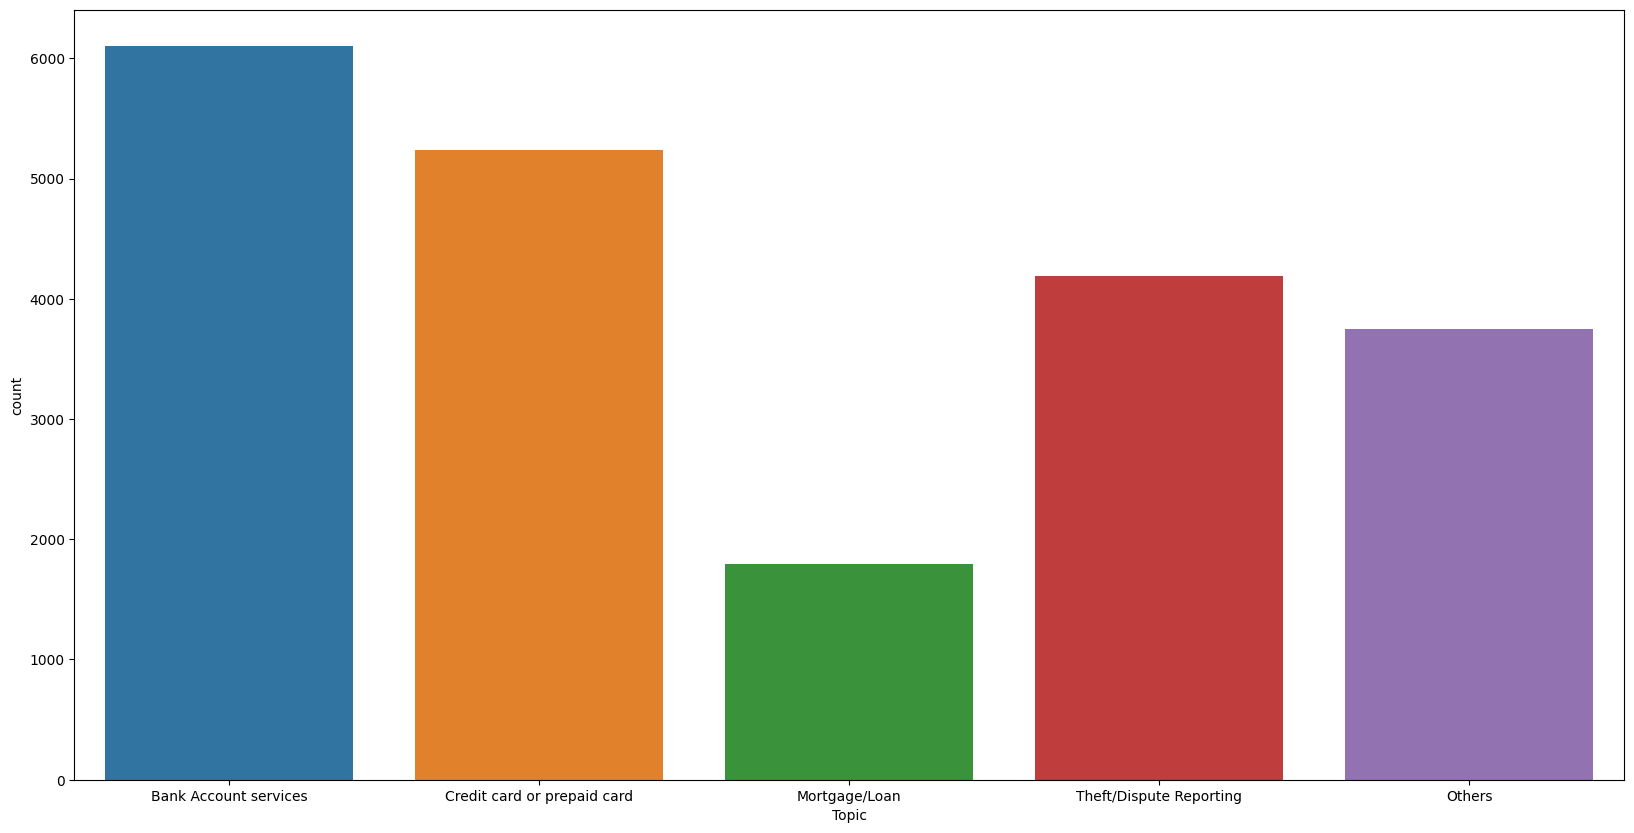

In [ ]:
fig = plt.figure(figsize = (20,10))
sns.countplot(x='Topic', data = data_clean)

In [ ]:
data_clean['Topic'].unique()

array(['Bank Account services', 'Credit card or prepaid card',
       'Mortgage/Loan', 'Theft/Dispute Reporting', 'Others'], dtype=object)

In [ ]:
training_data = data_clean[['complaint_text','Topic']]

In [ ]:
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,Bank Account services
10,chase card was reported on however fraudulent ...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,Bank Account services


In [ ]:
# reverse_topic_mapping = {
#     'Bank Account services' :0,
#     'Credit card or prepaid card':1,
#     'Others':2,
#     'Theft/Dispute Reporting':3,
#     'Mortgage/Loan':4

# }

# training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
# training_data.head()
training = training_data.copy()
topic_reverse = []
topic = np.array(training['Topic'])
for i in range(len(topic)):
  if(topic[i] == 'Bank Account services'):
    topic_reverse.append(0)
  if(topic[i] == 'Credit card or prepaid card'):
    topic_reverse.append(1)
  if(topic[i] == 'Others'):
    topic_reverse.append(2)
  if(topic[i] == 'Theft/Dispute Reporting'):
    topic_reverse.append(3)
  if(topic[i] == 'Mortgage/Loan'):
    topic_reverse.append(4)

training.drop(['Topic'],axis = 1, inplace = True)
training['Topic'] = topic_reverse

In [ ]:
len(topic)

21072

In [ ]:
len(topic_reverse)

21072

In [ ]:
training['Topic']

1        0
2        0
10       1
11       1
14       0
        ..
78303    1
78309    3
78310    0
78311    4
78312    4
Name: Topic, Length: 21072, dtype: int64

In [ ]:
training['Topic'].isnull().sum()

0

In [ ]:
training[['complaint_text','Topic']][training.Topic == 2].head(30)

,complaint_text,Topic
57,i have been trying to do a loan modification w...,2
73,i have wired through one of chase branches in ...,2
81,i bought a new xxxx xxxx on xxxxxxxx from xxxx...,2
99,my name is xxxx xxxx i have missed a payment i...,2
127,i am xxxx military member xxxx with the xxxx...,2
156,chase issued a mortgage loan against my proper...,2
203,jp morgan and chase reported loans xxxx xxx...,2
213,my mortgage is with chase my payments were bei...,2
265,i am submitting a complaint regarding the acti...,2
293,i ask chase auto finance please honor the writ...,2


In [ ]:
x = training.complaint_text
y = training.Topic

In [ ]:
y.isnull().sum()

0

In [ ]:
x.isnull().sum()

0

In [ ]:
y.shape

(21072,)

In [ ]:
# y.fillna(y.median(),inplace = True)

In [ ]:
y.isnull().sum()

0

In [ ]:
count_vect = CountVectorizer()
x_vect = count_vect.fit_transform(x)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_vect)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_tfidf, y, test_size = 0.25, random_state = 40, stratify = y)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

In [ ]:
metric1 = []
y_pred = mnb.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
model_report_test = classification_report(y_test,y_pred)
print('Classification Report for Test:\n',model_report_test)


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.54      0.95      0.69      1525
           1       0.69      0.74      0.71      1310
           2       0.92      0.64      0.75       937
           3       0.89      0.47      0.62      1047
           4       0.00      0.00      0.00       449

    accuracy                           0.66      5268
   macro avg       0.61      0.56      0.55      5268
weighted avg       0.67      0.66      0.63      5268



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
class_labels = training['Topic'].unique()

In [ ]:
class_labels

array([0, 1, 4, 3, 2])

In [ ]:
# fig = plt.subplots(figsize=(12, 8))
# cm = confusion_matrix(y_test, y_pred)
# cmp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
# cmp.plot(cmap = plt.cm.Blues)
# plt.xticks(rotation=80)
# plt.show()

In [ ]:
lr_model = LogisticRegression(random_state = 40, solver = 'liblinear')
lr_model.fit(x_train,y_train)

LogisticRegression(random_state=40, solver='liblinear')

In [ ]:
y_pred = lr_model.predict(x_test)
model_report = classification_report(y_test,y_pred)
print("Classification report :\n", model_report)

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      1525
           1       0.91      0.92      0.92      1310
           2       0.95      0.92      0.93       937
           3       0.90      0.91      0.90      1047
           4       0.94      0.78      0.85       449

    accuracy                           0.91      5268
   macro avg       0.92      0.89      0.91      5268
weighted avg       0.91      0.91      0.91      5268



In [ ]:
dtc = DecisionTreeClassifier(random_state = 40)
dtc.fit(x_train,y_train)
y_pred = dtc.predict(x_test)
model_report = classification_report(y_test,y_pred)
print("Classification report :\n",model_report )

Classification report :
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1525
           1       0.80      0.81      0.80      1310
           2       0.83      0.82      0.83       937
           3       0.71      0.72      0.72      1047
           4       0.71      0.70      0.71       449

    accuracy                           0.78      5268
   macro avg       0.77      0.77      0.77      5268
weighted avg       0.78      0.78      0.78      5268



In [ ]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 40, n_jobs = -1, oob_score = True)
rf.fit(x_train,y_train)

print('OOB SCORE : ', rf.oob_score_)
y_pred = rf.predict(x_test)
model_report = classification_report(y_test,y_pred)
print("Classification report:\n", model_report)

OOB SCORE :  0.8153631991900785
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85      1525
           1       0.81      0.87      0.84      1310
           2       0.89      0.86      0.87       937
           3       0.86      0.80      0.83      1047
           4       0.96      0.28      0.43       449

    accuracy                           0.82      5268
   macro avg       0.86      0.75      0.76      5268
weighted avg       0.84      0.82      0.81      5268



In [ ]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 40)

In [ ]:
def gridSearch(model,folds, params,scoring):
  grid_search = GridSearchCV(model,
                             cv = folds,
                             param_grid = params,
                             scoring = scoring,
                             n_jobs = -1,
                             verbose = 1)
  return grid_search

In [ ]:
def print_best_params(model):
  print("Best Score : ", model.best_score_)
  print("Best Hyperparameter :", model.best_params_)

In [ ]:
mnb = MultinomialNB()
mnb_params = {'alpha' : (1, 0.1, 0.01, 0.001, 0.0001)}
grid_search_mnb = gridSearch(mnb, folds, mnb_params, scoring = None)
grid_search_mnb.fit(x_train, y_train)
print_best_params(grid_search_mnb)
y_pred = grid_search_mnb.predict(x_test)
print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score :  0.765819561186774
Best Hyperparameter : {'alpha': 0.01}
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1525
           1       0.73      0.75      0.74      1310
           2       0.84      0.84      0.84       937
           3       0.77      0.72      0.75      1047
           4       0.62      0.43      0.50       449

    accuracy                           0.76      5268
   macro avg       0.74      0.72      0.73      5268
weighted avg       0.76      0.76      0.76      5268



In [ ]:
lr_model = LogisticRegression()
lr_params = {'C' : [0.01, 1, 10],
             'penalty' : ['l1','l2'],
             'solver' : ['liblinear','newton-cg','saga']}
grid_search_lr =  gridSearch(lr_model,folds,lr_params,scoring=None)
grid_search_lr.fit(x_train,y_train)
print_best_params(grid_search_lr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best Score :  0.9311568402884843
Best Hyperparameter : {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
y_pred = grid_search_lr.predict(x_test)
print('Classification report :\n', classification_report(y_test,y_pred))

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1525
           1       0.94      0.93      0.93      1310
           2       0.95      0.94      0.94       937
           3       0.90      0.94      0.92      1047
           4       0.93      0.91      0.92       449

    accuracy                           0.94      5268
   macro avg       0.93      0.93      0.93      5268
weighted avg       0.94      0.94      0.94      5268



In [ ]:
dtc = DecisionTreeClassifier(random_state = 40)
dtc_params = {
    'max_depth' : [5,10,20,30],
    'min_samples_leaf' : [5,10,20,30]
}

grid_search_dtc = gridSearch(dtc,folds,dtc_params,scoring=None)
grid_search_dtc.fit(x_train,y_train)
print_best_params(grid_search_dtc)
y_pred = grid_search_dtc.predict(x_test)
print('Classification report :\n', classification_report(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score :  0.7937231648372771
Best Hyperparameter : {'max_depth': 20, 'min_samples_leaf': 20}
Classification report :
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      1525
           1       0.81      0.84      0.82      1310
           2       0.82      0.85      0.83       937
           3       0.79      0.74      0.77      1047
           4       0.84      0.72      0.78       449

    accuracy                           0.80      5268
   macro avg       0.81      0.79      0.80      5268
weighted avg       0.80      0.80      0.80      5268



In [ ]:
rfc = RandomForestClassifier(random_state = 40, n_jobs = -1, oob_score = True)
rfc_params = {'max_depth' : [10,20,30],
              'min_samples_leaf' : [5,10,15],
              'n_estimators' : [100,200,300]}
grid_search_rfc = gridSearch(rfc,folds,rfc_params,scoring = None)
grid_search_rfc.fit(x_train,y_train)
print('OOB Score:', grid_search_rfc.best_estimator_.oob_score_)
print_best_params(grid_search_rfc)
y_pred = grid_search_rfc.predict(x_test)
print("Classification report\n" , classification_report(y_test,y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
OOB Score: 0.7725892179195141
Best Score :  0.7760057504635209
Best Hyperparameter : {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 300}
Classification report
               precision    recall  f1-score   support

           0       0.74      0.93      0.82      1525
           1       0.74      0.87      0.80      1310
           2       0.89      0.82      0.85       937
           3       0.85      0.73      0.78      1047
           4       0.98      0.12      0.21       449

    accuracy                           0.79      5268
   macro avg       0.84      0.69      0.70      5268
weighted avg       0.81      0.79      0.76      5268



In [ ]:
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [ ]:
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)
prediction = grid_search_lr.predict(test_tfidf)
prediction

array([3])

In [ ]:
topic_mapping[prediction[0]]

'Theft/Dispute Reporting'